<a href="https://colab.research.google.com/github/nagpalpu/cycleGANs/blob/main/Monet_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def show_images(img, nrow=5, title="", normalization_range=(-1, 1)):
    if not isinstance(img, torch.Tensor):
        raise ValueError("Input img should be a torch.Tensor")

    # Normalization adjustment based on specified range
    scale = normalization_range[1] - normalization_range[0]
    img = img.detach().cpu() * 0.5 + 0.5

    img_grid = torchvision.utils.make_grid(img, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(8, 5))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()



Next, we are defining a custom dataset class named MonetPhotoDataset for your GAN project, which inherits from PyTorch's Dataset class. This class is designed to handle loading and transforming two types of image datasets: Monet paintings and regular photos. In the constructor (init), the class initializes paths to the directories containing Monet and photo images, along with an optional transformation. It then populates lists of file paths for both Monet paintings and regular photos, filtering for specific image file extensions. The getitem method is responsible for loading and optionally transforming a pair of images (one Monet painting and one photo) based on the provided index. It ensures that each pair is loaded and transformed correctly, which is crucial for training the GAN. The len method returns the maximum length of the two datasets, ensuring that the DataLoader can iterate over the dataset correctly.


In [ ]:


import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class MonetPhotoDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, apply_transform=None):
        if not os.path.isdir(monet_dir) or not os.path.isdir(photo_dir):
            raise ValueError("Provided folder paths are invalid or do not exist.")

        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.apply_transform = apply_transform
        self.monet_images = [os.path.join(monet_dir, file) for file in os.listdir(monet_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]
        self.photo_images = [os.path.join(photo_dir, file) for file in os.listdir(photo_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]

        if not self.monet_images or not self.photo_images:
            raise ValueError("No images found in the provided directory paths.")

    def __getitem__(self, index):
        monet_img_path = self.monet_images[index % len(self.monet_images)]
        photo_img_path = self.photo_images[index % len(self.photo_images)]

        try:
            monet_img = np.array(Image.open(monet_img_path).convert('RGB')).astype('float32')
            photo_img = np.array(Image.open(photo_img_path).convert('RGB')).astype('float32')
        except IOError:
            raise IOError("Error occurred when reading images.")

        if self.apply_transform:
            try:
                transformed_images = self.apply_transform(image=monet_img, image0=photo_img)
                monet_img = transformed_images["image"]
                photo_img = transformed_images["image0"]
            except Exception as e:
                raise RuntimeError("An error occurred during transformation: " + str(e))

        return monet_img, photo_img

    def __len__(self):
        return max(len(self.monet_images), len(self.photo_images))





Finally, we are setting up the configuration for the deep learning model and preparing the data for training. Initially, we determine the device for training ('cuda' for GPU or 'cpu'), which is crucial for efficient computation. Then, we define several hyperparameters, such as the number of training epochs, learning rates for the discriminator and generator, the number of workers for data loading, batch size, image size, and the number of channels in the images. Additional parameters like lambda values for cycle consistency and identity losses, and a flag for saving the model, are also set, indicating their role in the training process. We then specify file names for saving the checkpoints of different models (discriminator for Monet, discriminator for photos, generator for Monet, and generator for photos).

In [ ]:
# Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters Configuration
hyperparams = {
    "num_epochs": 35,
    "learning_rate_discriminator": 2e-4,
    "learning_rate_generator": 2e-4,
    "num_workers": 2,
    "batch_size": 8,
    "image_dimensions": {"size": 128, "channels": 3},
    "lambda_cycle_consistency": 10.0,
    "lambda_identity": 5.0,
    "save_model": True
}

# Model Checkpoint Paths
checkpoint_paths = {
    "discriminator_monet": "discM.pth.tar",
    "discriminator_photo": "discP.pth.tar",
    "generator_monet": "genM.pth.tar",
    "generator_photo": "genP.pth.tar"
}

# Image Transformations
image_transforms = A.Compose(
    [
        A.Resize(hyperparams["image_dimensions"]["size"], hyperparams["image_dimensions"]["size"]),
        A.HorizontalFlip(),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2(),
    ], additional_targets={"image0": "image"}
)

# Dataset and DataLoader Setup
train_dataset = MonetPhotoDataset("/content/data/monet_jpg", "/content/data/photo_jpg", apply_transform=image_transforms)
train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, num_workers=hyperparams["num_workers"])

In [ ]:
print(f"Total monet images: {len(train_dataset)}")

Total monet images: 7038


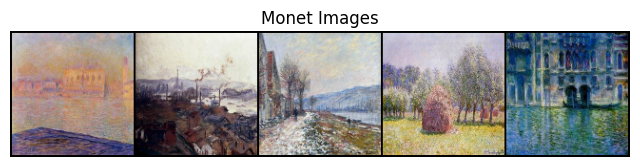

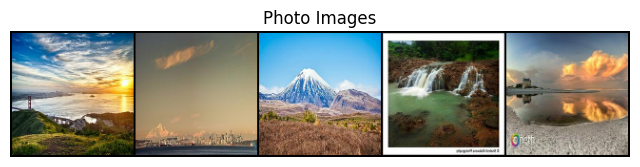

In [ ]:
num_images_to_show = 5

monet_img, photo_img = next(iter(train_loader))
show_images(monet_img[:num_images_to_show], nrow=5, title="Monet Images")
show_images(photo_img[:num_images_to_show], nrow=5, title="Photo Images")

Uploading the data

In [ ]:
!pip install kaggle

In [ ]:
!kaggle competitions download -c gan-getting-started

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paridhidoesml","key":"653e8ece4e0e136483484468c072d11c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c gan-getting-started

 98% 361M/367M [00:09<00:00, 41.4MB/s]
100% 367M/367M [00:09<00:00, 40.8MB/s]


In [ ]:
!unzip gan-getting-started.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/photo_jpg/46e84039a1.jpg  
  inflating: data/photo_jpg/46f391abec.jpg  
  inflating: data/photo_jpg/46f5ef1042.jpg  
  inflating: data/photo_jpg/4706619607.jpg  
  inflating: data/photo_jpg/4707b03a08.jpg  
  inflating: data/photo_jpg/47100a9939.jpg  
  inflating: data/photo_jpg/471f4755b9.jpg  
  inflating: data/photo_jpg/472b351bc4.jpg  
  inflating: data/photo_jpg/472d5ac100.jpg  
  inflating: data/photo_jpg/4758e5dd4c.jpg  
  inflating: data/photo_jpg/4762bb79ef.jpg  
  inflating: data/photo_jpg/4778b13518.jpg  
  inflating: data/photo_jpg/4787b82d37.jpg  
  inflating: data/photo_jpg/478e07feaa.jpg  
  inflating: data/photo_jpg/478eb12a82.jpg  
  inflating: data/photo_jpg/479698b371.jpg  
  inflating: data/photo_jpg/4796d67f61.jpg  
  inflating: data/photo_jpg/47aad493bd.jpg  
  inflating: data/photo_jpg/47ae0edd23.jpg  
  inflating: data/photo_jpg/47b94957ff.jpg  
  inflating: data/photo_jpg/47bb43fe3e.jpg  
  in

Done uploading the data using kaggle API

In [ ]:
monet_img, photo_img = next(iter(train_loader))
monet_img.shape


torch.Size([8, 3, 128, 128])

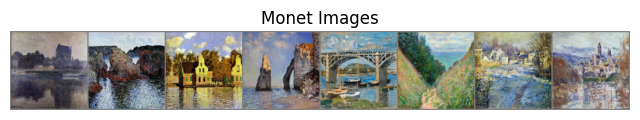

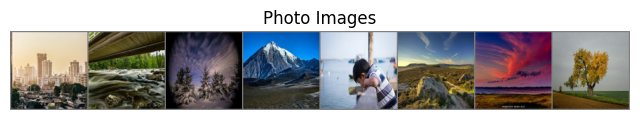

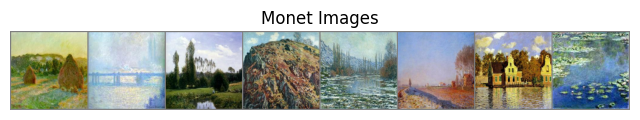

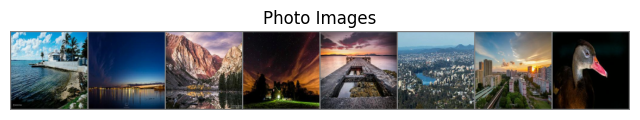

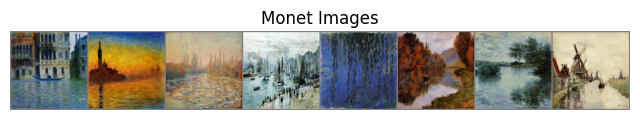

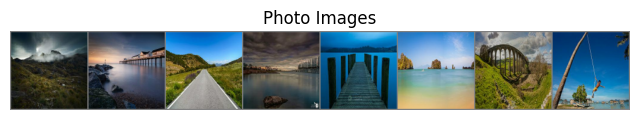

In [ ]:
batch_count = 0
for monet_imgs, photo_imgs in train_loader:
      if batch_count >= 3:
        break

      show_images(torchvision.utils.make_grid(monet_imgs), nrow=5, title="Monet Images")
      show_images(torchvision.utils.make_grid(photo_imgs), title="Photo Images")

      batch_count += 1